<a href="https://colab.research.google.com/github/Newtypez/Newtypez/blob/main/cs434_mall_customers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
#Install UMAP
!pip3 install umap-learn
!pip3 install umap-learn[plot]

In [ ]:
#Data Manipulation, Linear Algebra
import numpy as np
import pandas as pd

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import silhouette_score
import umap
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.cluster import KMeans

# Import dataset

In [ ]:
url = '/content/sample_data/Mall_Customers.csv'
df = pd.read_csv(url)
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# Check

In [ ]:
#ดูสรุปชุดข้อมูล
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
#ดูสรุปสถิติของตัวแปรตัวเลข
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [ ]:
#เช็คว่ามีค่า null ไหม
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [ ]:
#เช็คจำนวนคอลัมน์และจำนวนแถว
df = df[['CustomerID','Gender','Age','Annual Income (k$)','Spending Score (1-100)']]
df.shape

(200, 5)

# Pre-processing

In [ ]:
#เปลี่ยนชื่อคอลัมน์ Annual Income (k$) => Annual_Income
df.rename(columns= {'Annual Income (k$)': 'Annual_Income'}, inplace=True )

#เปลี่ยนชื่อคอลัมน์ Spending Score (1-100) => Spending_Score_1_100
df.rename(columns= {'Spending Score (1-100)': 'Spending_Score_1_100'}, inplace=True )
df.head()

,CustomerID,Gender,Age,Annual_Income,Spending_Score_1_100
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
#เปลี่ยนค่าของข้อมูล Gender ให้ Male = 0 และ Female = 1
df['Gender'] = df['Gender'].replace('Male','0')
df['Gender'] = df['Gender'].replace('Female','1')
df.head()

,CustomerID,Gender,Age,Annual_Income,Spending_Score_1_100
0,1,0,19,15,39
1,2,0,21,15,81
2,3,1,20,16,6
3,4,1,23,16,77
4,5,1,31,17,40


In [ ]:
#ตรวจสอบประเภทของข้อมูล
df.dtypes

CustomerID               int64
Gender                  object
Age                      int64
Annual_Income            int64
Spending_Score_1_100     int64
dtype: object

In [ ]:
#เปลี่ยนประเภทของ Gender จาก object ให้เป็น int
df['Gender'] = df['Gender'].astype(int)
df.dtypes

CustomerID              int64
Gender                  int64
Age                     int64
Annual_Income           int64
Spending_Score_1_100    int64
dtype: object

# EDA

In [ ]:
#ดูสรุปสถิติของตัวแปรตัวเลข
df = df[['Gender','Age','Annual_Income','Spending_Score_1_100']]
df.describe()

,Gender,Age,Annual_Income,Spending_Score_1_100
count,200.000000,200.000000,200.000000,200.000000
mean,0.560000,38.850000,60.560000,50.200000
std,0.497633,13.969007,26.264721,25.823522
min,0.000000,18.000000,15.000000,1.000000
25%,0.000000,28.750000,41.500000,34.750000
50%,1.000000,36.000000,61.500000,50.000000
75%,1.000000,49.000000,78.000000,73.000000
max,1.000000,70.000000,137.000000,99.000000


In [ ]:
df.groupby('Gender')['Spending_Score_1_100'].mean()

Gender
0    48.511364
1    51.526786
Name: Spending_Score_1_100, dtype: float64

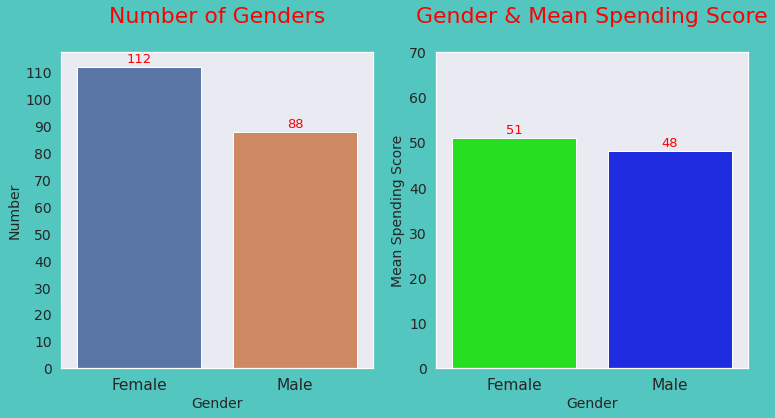

In [ ]:
#มาลองทำความเข้าใจความสัมพันธ์ระหว่างเพศกับคะแนนการใช้จ่ายกัน
spending_score_male = 0
spending_score_female = 0

for i in range(len(df)):
  if df['Gender'][i] == 0:
    spending_score_male = spending_score_male + df['Spending_Score_1_100'][i]
  if df['Gender'][i] == 1:
    spending_score_female = spending_score_female + df['Spending_Score_1_100'][i]

#Number of genders
plt.figure(figsize=(16,16),facecolor='#54C6C0')
plt.subplot(3,3,1)
plots = sns.barplot(x=['Female','Male'], y=df['Gender'].value_counts(), data=df)  

for bar in plots.patches:
  plots.annotate(format(bar.get_height(), '.0f'), 
                 (bar.get_x() + bar.get_width() / 2, 
                  bar.get_height()), ha='center', va='center',
                 size=13, xytext=(0, 8),
                 textcoords='offset points',color='red')

plt.xlabel("Gender", size=14)
plt.ylabel("Number", size=14)
plt.yticks(np.arange(0,116,10),size='14')
plt.grid(False)
plt.title("Number of Genders\n", color="red", size='22')

#Gender & Mean Spending Score
list_genders_spending_score_mean = [int(spending_score_female/df['Gender'].value_counts()[1]),int(spending_score_male/df['Gender'].value_counts()[0])]
series_genders_spending_score_mean = pd.Series(data = list_genders_spending_score_mean)

plt.subplot(3,3,2)
plots = sns.barplot(x=['Female','Male'], y=series_genders_spending_score_mean, palette='hsv')  

for bar in plots.patches:
  plots.annotate(format(bar.get_height(), '.0f'), 
                 (bar.get_x() + bar.get_width() / 2, 
                  bar.get_height()), ha='center', va='center',
                 size=13, xytext=(0, 8),
                 textcoords='offset points',color='red')

plt.xlabel("Gender", size=14)
plt.ylabel("Mean Spending Score", size=14)
plt.yticks(np.arange(0,71,10),size='14')
plt.grid(False)
plt.title("Gender & Mean Spending Score\n", color="red", size='22')
plt.tight_layout()
plt.show()

เราเข้าใจอะไรจาก 2 กราฟนี้?

คะแนนการใช้จ่ายเฉลี่ยของชายและหญิงไม่มีความแตกต่างกันอย่างมีนัยสำคัญ เนื่องจากคะแนนการใช้จ่ายเฉลี่ยอยู่ใกล้กันมาก ความแตกต่างระหว่างจำนวนลูกค้าชายและหญิง แต่ความแตกต่างนี้ไม่ร้ายแรง เมื่อพิจารณาทั้งหมดนี้ การเลือกกลุ่มเป้าหมายตามเพศก็ไม่มีความหมาย ✓

In [ ]:
#ดูสรุปสถิติของตัวแปรตัวเลขเมื่อนำ Gender ออก
df = df[['Age','Annual_Income','Spending_Score_1_100']]
df.describe()

,Age,Annual_Income,Spending_Score_1_100
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


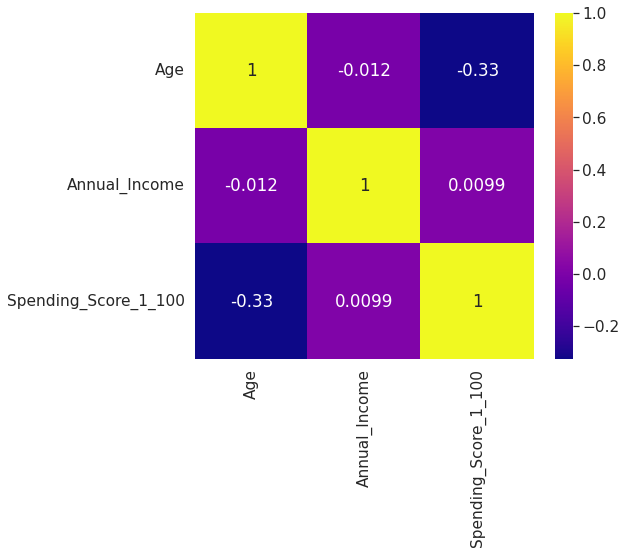

In [ ]:
cor = df.corr()
sns.set(font_scale=1.4)
plt.figure(figsize=(9,8))
sns.heatmap(cor, annot=True, cmap='plasma')
plt.tight_layout()
plt.show()

จากตารางความสัมพันธ์นี้ชัดเจนว่าลูกค้าสูงอายุมีรายได้น้อยจึงใช้จ่ายเงินน้อยลง

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



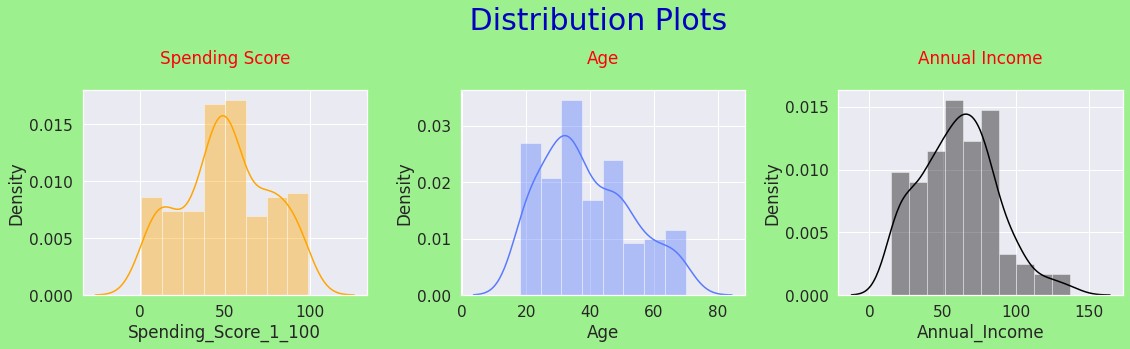

In [ ]:
#Distribution Plots
plt.figure(figsize=(16,12),facecolor='#9DF08E')

#Spending Score
plt.subplot(3,3,1)
plt.title('Spending Score\n', color='#FF000B')
sns.distplot(df['Spending_Score_1_100'], color='orange')

#Age
plt.subplot(3,3,2)
plt.title('\n\nAge\n', color='#FF000B')
sns.distplot(df['Age'], color='#577AFF')

#Annual Income 
plt.subplot(3,3,3)
plt.title('Annual Income\n', color='#FF000B')
sns.distplot(df['Annual_Income'], color='black')

plt.suptitle('       Distribution Plots\n', color='#0000C1', size = 30)
plt.tight_layout()

Text(0.5, 1.0, 'Age - Spending Score')

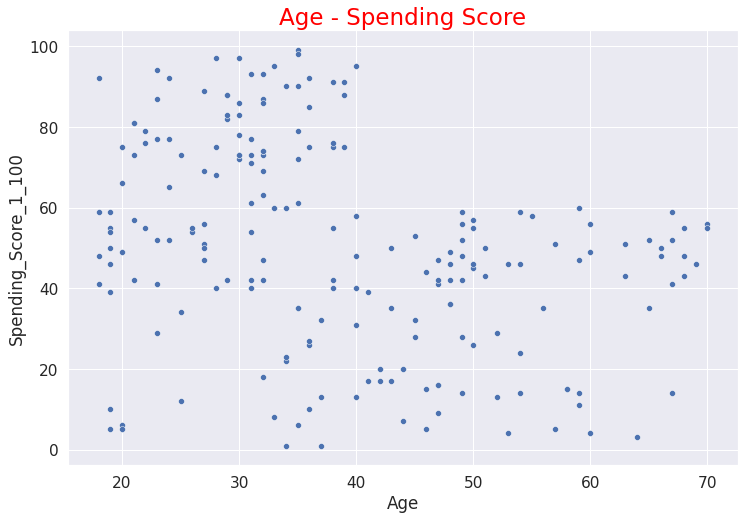

In [ ]:
#มาดูความสัมพันธ์ระหว่างคะแนนอายุกับการใช้จ่าย
plt.figure(figsize=(12,8))
sns.scatterplot(x = df['Age'], y = df['Spending_Score_1_100'])
plt.title('Age - Spending Score', size = 23, color='red')

ผู้ที่มีอายุระหว่าง 20-40 ปีซื้อสินค้ามากขึ้น

Text(0.5, 1.0, 'Annual Income - Spending Score')

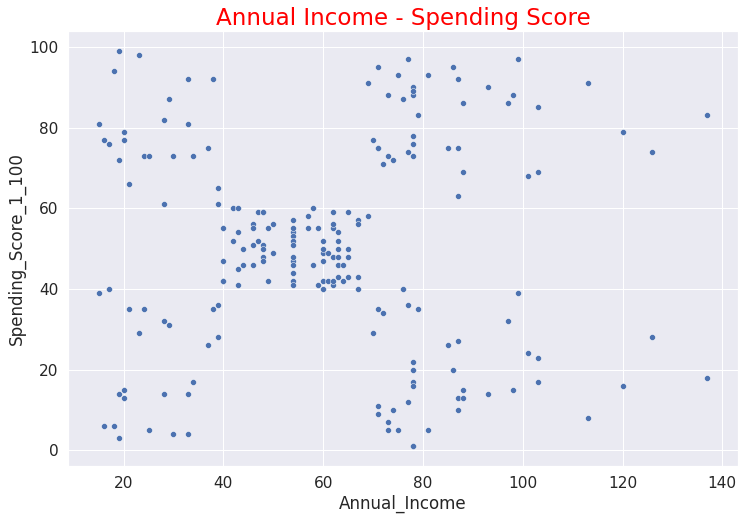

In [ ]:
#มาดูความสัมพันธ์ระหว่างรายได้กับคะแนนการใช้จ่าย
plt.figure(figsize=(12,8))
sns.scatterplot(x = df['Annual_Income'], y = df['Spending_Score_1_100'], palette = "red")
plt.title('Annual Income - Spending Score', size = 23, color='red')

สามารถเห็นได้ชัดว่าแบ่งเป็น 5 กลุ่มเป้าหมายชัดเจน เช่น รายได้น้อย ใช้จ่ายน้อย , รายได้น้อย ใช้จ่ายมาก , รายได้กลางๆ ใช้จ่ายกลางๆ , รายได้มาก ใช้จ่ายน้อย , รายได้มาก ใช้จ่ายมาก

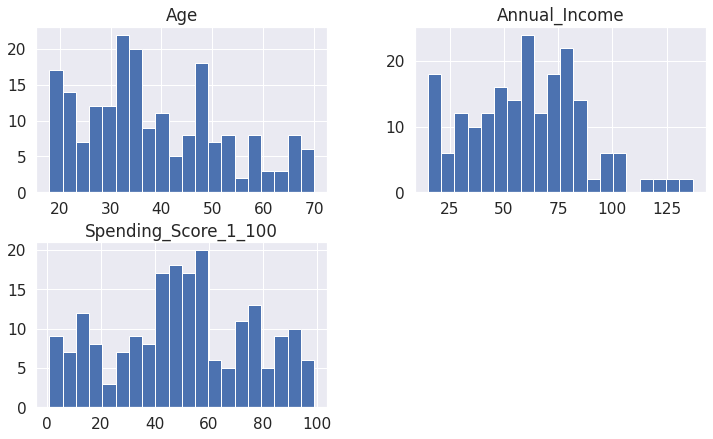

In [ ]:
#เช็คสถิติข้อมูล
plt.rcParams["figure.figsize"] = (12, 7)
df.hist(bins=20)
plt.show()

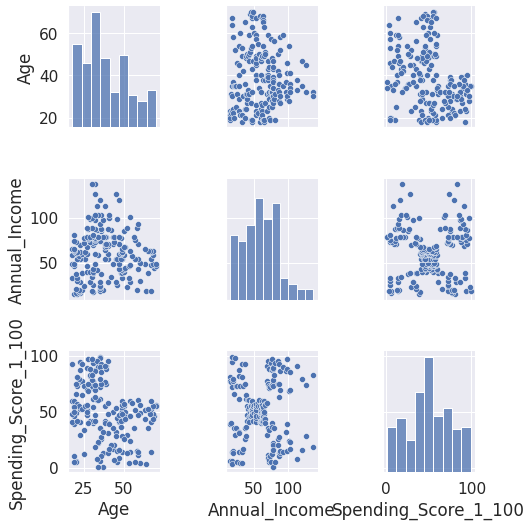

In [ ]:
#เปรียบเทียบแต่ละข้อมูล
sns.pairplot(df)
plt.show()

# Feature Engineering

จะทำให้ข้อมูลของ data เป็น normalized เพื่อที่ให้ง่ายต่อการวิเคราะห์ข้อมูลโดยเริ่มจาก scaled ข้อมูลและใช้

- **Box-Cox** จะทำงานได้กับเฉพาะ data ที่มีข้อมูลเป็นค่าบวกเท่านั้น
- **Yeo-Johnson** จะทำงานกับ data ที่มีข้อมูลที่เป็นทั้งค่าบวกและค่าลบ

เพื่อทำให้ข้อมูลเป็น normalized

In [ ]:
df.head()

,Age,Annual_Income,Spending_Score_1_100
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


In [ ]:
#for Box-Cox Transformation
boxcox = PowerTransformer(method='box-cox')
boxcoxdf = boxcox.fit_transform(df)
boxcoxdf = pd.DataFrame(boxcoxdf, columns=df.columns)
boxcoxdf.head()

,Age,Annual_Income,Spending_Score_1_100
0,-1.721289,-1.993338,-0.379478
1,-1.470832,-1.993338,1.160598
2,-1.593393,-1.933220,-1.831904
3,-1.239931,-1.933220,1.021130
4,-0.460068,-1.874404,-0.340306


In [ ]:
#for Yeo-Johnson Transformation
yeo = PowerTransformer(method='yeo-johnson')
yeodf = yeo.fit_transform(df)
yeodf = pd.DataFrame(yeodf, columns=df.columns)
yeodf.head()

,Age,Annual_Income,Spending_Score_1_100
0,-1.718993,-1.989930,-0.385308
1,-1.470002,-1.989930,1.164467
2,-1.591912,-1.930366,-1.820424
3,-1.240020,-1.930366,1.023549
4,-0.461118,-1.872032,-0.346103


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/di

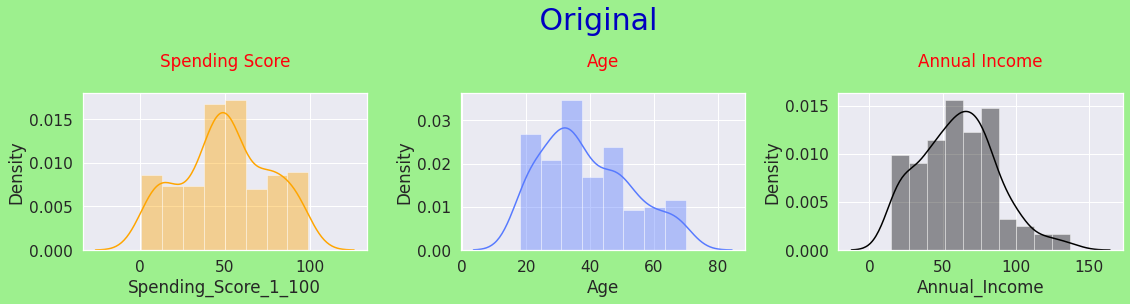

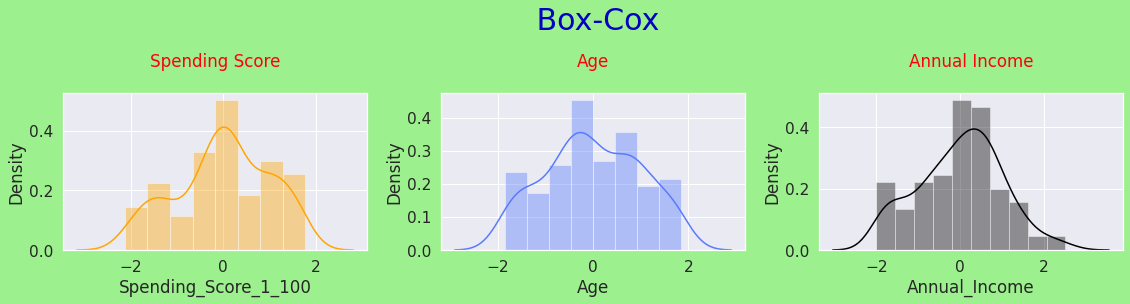

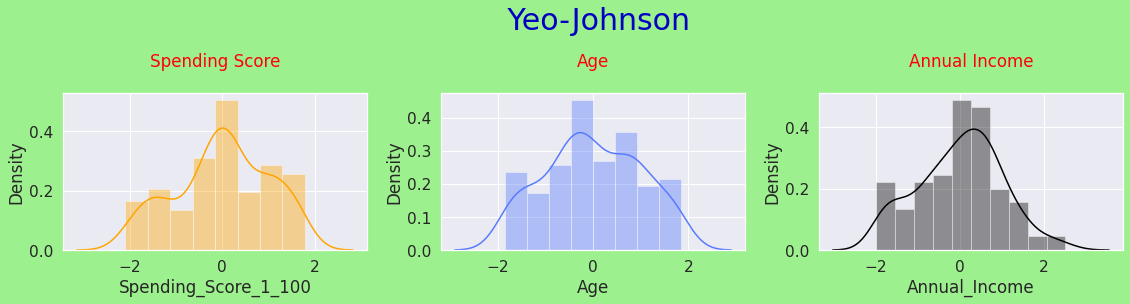

In [ ]:
#Original
plt.figure(figsize=(16,10),facecolor='#9DF08E')

#Spending Score
plt.subplot(3,3,1)
plt.title('Spending Score\n', color='#FF000B')
sns.distplot(df['Spending_Score_1_100'], color='orange')

#Age
plt.subplot(3,3,2)
plt.title('\n\nAge\n', color='#FF000B')
sns.distplot(df['Age'], color='#577AFF')

#Annual Income 
plt.subplot(3,3,3)
plt.title('Annual Income\n', color='#FF000B')
sns.distplot(df['Annual_Income'], color='black')

plt.suptitle('       Original\n', color='#0000C1', size = 30)
plt.tight_layout()

#Box-Cox
plt.figure(figsize=(16,10),facecolor='#9DF08E')

#Spending Score
plt.subplot(3,3,1)
plt.title('Spending Score\n', color='#FF000B')
sns.distplot(boxcoxdf['Spending_Score_1_100'], color='orange')

#Age
plt.subplot(3,3,2)
plt.title('\n\nAge\n', color='#FF000B')
sns.distplot(boxcoxdf['Age'], color='#577AFF')

#Annual Income 
plt.subplot(3,3,3)
plt.title('Annual Income\n', color='#FF000B')
sns.distplot(boxcoxdf['Annual_Income'], color='black')

plt.suptitle('       Box-Cox\n', color='#0000C1', size = 30)
plt.tight_layout()

#Yeo-Johnson Plots
plt.figure(figsize=(16,10),facecolor='#9DF08E')

#Spending Score
plt.subplot(3,3,1)
plt.title('Spending Score\n', color='#FF000B')
sns.distplot(yeodf['Spending_Score_1_100'], color='orange')

#Age
plt.subplot(3,3,2)
plt.title('\n\nAge\n', color='#FF000B')
sns.distplot(yeodf['Age'], color='#577AFF')

#Annual Income 
plt.subplot(3,3,3)
plt.title('Annual Income\n', color='#FF000B')
sns.distplot(yeodf['Annual_Income'], color='black')

plt.suptitle('       Yeo-Johnson\n', color='#0000C1', size = 30)
plt.tight_layout()

## KMeans Model

**Params**

ตั้งตัวแปรในการอ้างอิงและใช้ซ้ำ

In [ ]:
SEED = 4
COLUMNS=['Age','Annual_Income','Spending_Score_1_100']

# Modeling

เราจะทำการแยกข้อมูลเป็นกลุ่ม cluster k เพื่อใช้ในการจัดจำแนกกลุ่มเป้าหมายที่ต้องการโดยใช้ทั้ง **Box-Cox** และ **Yeo-Johnson**

## Box-Cox Elbow & Silhouette Score

In [ ]:
wssbc = []
silbc = []
#For possible 'k' values 2-14
k = range(2, 14)
for n in k:
    #initialize clustering model
    algorithm = (KMeans(n_clusters = n,random_state=SEED) )
    algorithm.fit(boxcoxdf)
    labels = algorithm.labels_
    df[f'box_k_{n}']=labels
    #store Weight of sum of squared distance & silhouette score
    wssbc.append(algorithm.inertia_)
    silbc.append(silhouette_score(boxcoxdf, labels, metric = 'euclidean'))

## Yeo-Johnson Elbow & Silhouette Score

In [ ]:
wssyeo = []
silyeo = []
for n in k:
    #initialize clustering model
    algorithm = (KMeans(n_clusters = n,random_state=SEED) )
    algorithm.fit(yeodf)
    labels = algorithm.labels_
    df[f'yeo_k_{n}']=labels
    #store Weight of sum of squared distance
    wssyeo.append(algorithm.inertia_)
    silyeo.append(silhouette_score(yeodf, labels, metric = 'euclidean'))

**DataFrame**

สร้างไว้เพื่อง่ายต่อการค้นหาและนำมาใช้เช็คข้อมูล

In [ ]:
df

,Age,Annual_Income,Spending_Score_1_100,box_k_2,box_k_3,box_k_4,box_k_5,box_k_6,box_k_7,box_k_8,box_k_9,box_k_10,box_k_11,box_k_12,box_k_13,yeo_k_2,yeo_k_3,yeo_k_4,yeo_k_5,yeo_k_6,yeo_k_7,yeo_k_8,yeo_k_9,yeo_k_10,yeo_k_11,yeo_k_12,yeo_k_13
0,19,15,39,0,1,0,3,1,5,5,2,8,4,2,11,0,1,0,3,1,5,5,2,8,4,8,7
1,21,15,81,0,1,0,3,1,5,4,6,4,4,2,6,0,1,0,3,1,5,4,6,2,4,4,2
2,20,16,6,0,1,0,4,4,4,5,2,8,5,6,11,0,1,0,4,4,4,5,2,8,5,8,7
3,23,16,77,0,1,0,3,1,5,4,6,4,4,2,6,0,1,0,3,1,5,4,6,2,4,4,2
4,31,17,40,0,1,0,4,4,4,5,2,8,5,6,11,0,1,0,4,4,4,5,2,8,5,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,35,120,79,0,2,3,0,2,3,3,7,9,6,0,2,0,2,3,0,2,3,3,7,5,6,9,11
196,45,126,28,1,0,1,1,3,6,2,5,3,3,8,7,1,0,1,1,3,6,2,5,6,3,11,3
197,32,126,74,0,2,3,0,2,3,3,7,9,6,0,2,0,2,3,0,2,3,3,7,5,6,9,11
198,32,137,18,1,0,1,1,3,0,2,3,3,3,8,7,1,0,1,1,3,0,2,3,6,3,11,3


# Evaluate Elbow & Siloulette Score

เราจะใช้ตัว **Elbow** และ **Siloulette Score** ใช้และเปรียบเทียบในการหาข้อมูลดังนี้

- จุดตัดของกลุ่ม cluster
- คะแนนในแต่ละช่วงของกลุ่ม cluster
- กลุ่ม cluster ที่เหมาะจะนำมา **Interpretation** และ **Visualizing Clusters**

## Box-Cox

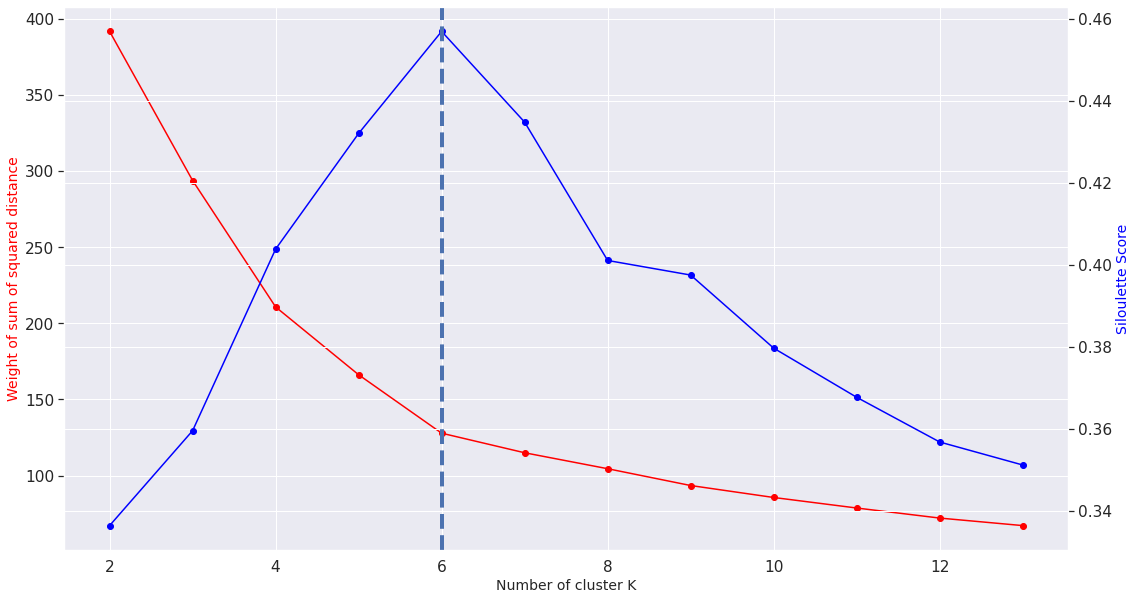

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(18,10)
ax.plot(k, wssbc, color="red", marker="o")
ax.set_xlabel("Number of cluster K",fontsize=14)
ax.set_ylabel("Weight of sum of squared distance",color="red",fontsize=14)

ax2=ax.twinx()
ax2.plot(k, silbc,color="blue",marker="o")
ax2.set_ylabel("Siloulette Score",color="blue",fontsize=14)

plt.axvline(6, lw=4, linestyle='--')
plt.show()

## Yeo-Johnson

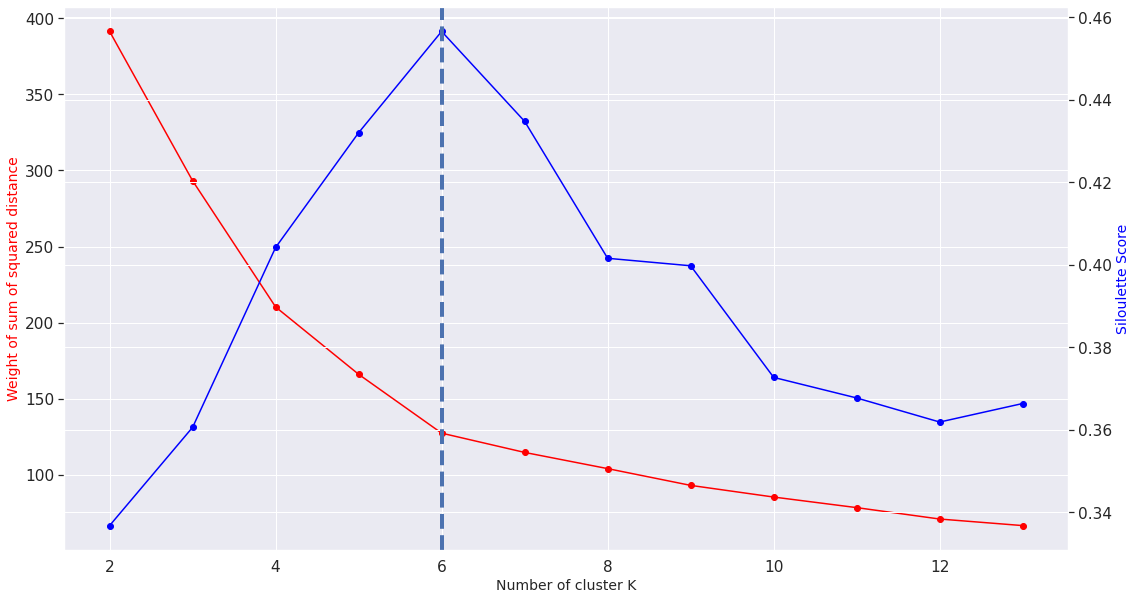

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(18,10)
ax.plot(k, wssyeo, color="red", marker="o")
ax.set_xlabel("Number of cluster K",fontsize=14)
ax.set_ylabel("Weight of sum of squared distance",color="red",fontsize=14)

ax2=ax.twinx()
ax2.plot(k, silyeo,color="blue",marker="o")
ax2.set_ylabel("Siloulette Score",color="blue",fontsize=14)

plt.axvline(6, lw=4, linestyle='--')
plt.show()

# Interpretation

- จะทำการนำข้อมูล custer k ที่เราเลือกจากช่วง evaluate มา plot โดยใช้ตัว **Violin Plot** ในการแยกข้อมูลของกลุ่ม custer เพื่อให้เห็นความแตกต่างของข้อมูลในแต่ละกลุ่ม custer ที่มีผลต่อข้อมูล

In [ ]:
#Color Mapping
def color_change_2d(data,col,k):
  if k==7:
    map = {0:'blue',1:'orange',2:'green',3:'red',4:'purple',5:'brown',6:'pink'}
  elif k==6:
    map = {0:'blue',1:'orange',2:'green',3:'red',4:'purple',5:'brown'}
  elif k==5:
    map = {0:'blue',1:'orange',2:'green',3:'red',4:'purple'}
  return data[col].map(map)

## Box-Cox

### K=7

In [ ]:
model = KMeans(n_clusters=7,random_state=SEED)
model.fit(boxcoxdf)
model.cluster_centers_.round(4)

array([[-0.6728,  1.0472, -1.6282],
       [-1.0964, -0.1136,  0.0201],
       [ 1.0524, -0.1668, -0.0025],
       [-0.3318,  0.9723,  1.1967],
       [ 0.4997, -1.4237, -1.2598],
       [-1.07  , -1.4474,  1.0355],
       [ 0.6822,  1.0193, -1.1625]])

In [ ]:
df.groupby('box_k_7')[COLUMNS].mean()

,Age,Annual_Income,Spending_Score_1_100
box_k_7,,,
0,29.363636,89.000000,10.454545
1,24.750000,55.781250,49.500000
2,54.137255,54.313725,48.862745
3,32.692308,86.538462,82.128205
4,45.400000,25.650000,18.550000
5,25.000000,25.260870,77.608696
6,47.333333,87.875000,20.416667


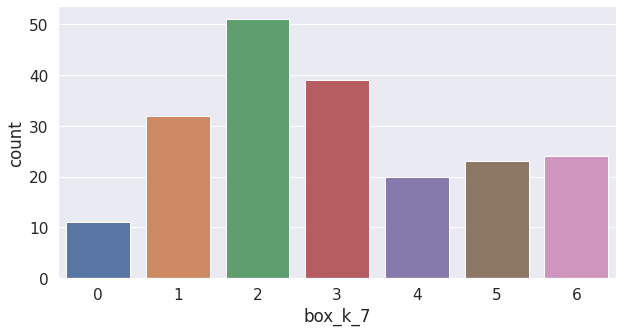

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x='box_k_7', data=df);

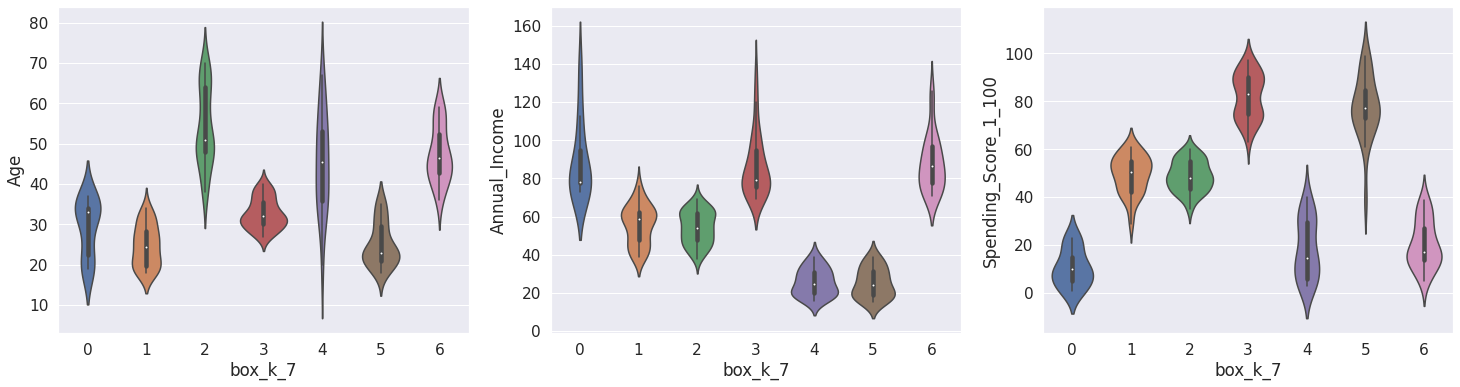

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,6))
ax = ax.ravel()
for pos, col in enumerate(COLUMNS):
  #use violinplot to see each cluster's variable is distrubuted
  sns.violinplot(x='box_k_7', y=col, data=df, ax=ax[pos])

**Box-Cox K = 7**
- custer 0 = กลุ่มวัยทำงาน มีรายได้มาก ใช้จ่ายน้อย
- custer 1 = กลุ่มวัยทำงาน มีรายได้กลางๆ ใช้จ่ายกลางๆ
- custer 2 = กลุ่มวัยก่อนเกษียณ มีรายได้กลางๆ ใช้จ่ายกลางๆ
- custer 3 = กลุ่มวัยกลางคน มีรายได้มาก ใช้จ่ายมาก
- custer 4 = กลุ่มวัยกลางคน มีรายได้น้อย ใช้จ่ายน้อย
- custer 5 = กลุ่มวัยทำงาน มีรายได้น้อย ใช้จ่ายมาก
- custer 6 = กลุ่มวัยกลางคน มีรายได้มาก ใช้จ่ายน้อย

In [ ]:
features = df[COLUMNS]
umap_2d = umap.UMAP(n_components=2, init='random', random_state=SEED)
proj_2d = umap_2d.fit_transform(features)

In [ ]:
fig = go.Figure(data=go.Scatter(x=proj_2d[:,0], y=proj_2d[:,1],
                 mode="markers",
                 marker=dict(color=color_change_2d(df,'box_k_7',7),size=5,showscale=False)))
fig.update_layout(height=500, title_text="Visualizing 2D Clusters K=7", showlegend=False)
fig.show()

### K=6

In [ ]:
model = KMeans(n_clusters=6,random_state=SEED)
model.fit(boxcoxdf)
model.cluster_centers_.round(4)

array([[ 1.0434, -0.1379, -0.0227],
       [-1.0145, -1.3892,  0.9872],
       [-0.3318,  0.9723,  1.1967],
       [ 0.4623,  1.1112, -1.3037],
       [ 0.4997, -1.4237, -1.2598],
       [-1.1881,  0.0109, -0.2102]])

In [ ]:
df.groupby('box_k_6')[COLUMNS].mean()

,Age,Annual_Income,Spending_Score_1_100
box_k_6,,,
0,53.962264,55.094340,48.339623
1,25.560000,26.480000,76.240000
2,32.692308,86.538462,82.128205
3,44.034483,90.793103,17.344828
4,45.400000,25.650000,18.550000
5,23.852941,59.088235,43.970588


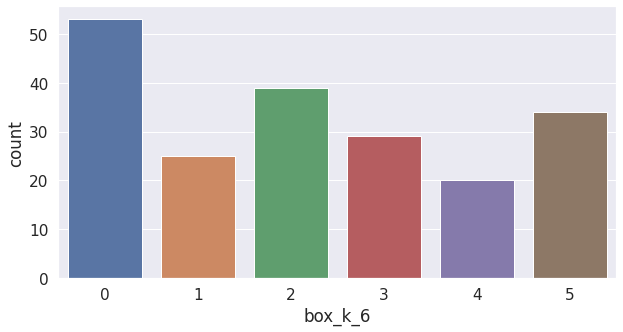

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x='box_k_6', data=df);

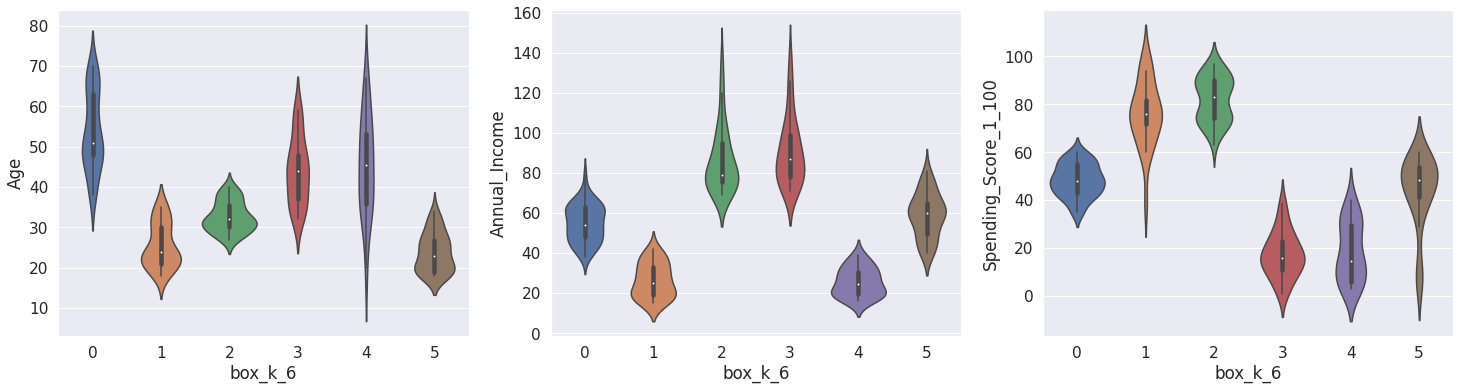

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,6))
ax = ax.ravel()
for pos, col in enumerate(COLUMNS):
  #use violinplot to see each cluster's variable is distrubuted
  sns.violinplot(x='box_k_6', y=col, data=df, ax=ax[pos])

**Box-Cox K = 6**
- custer 0 = กลุ่มวัยก่อนเกษียณ มีรายได้กลางๆ ใช้จ่ายกลางๆ
- custer 1 = กลุ่มวัยทำงาน มีรายได้น้อย ใช้จ่ายมาก
- custer 2 = กลุ่มวัยกลางคน มีรายได้มาก ใช้จ่ายมาก
- custer 3 = กลุ่มวัยกลางคน มีรายได้มาก ใช้จ่ายน้อย
- custer 4 = กลุ่มวัยกลางคน มีรายได้น้อย ใช้จ่ายน้อย
- custer 5 = กลุ่มวัยทำงาน มีรายได้กลางๆ ใช้จ่ายกลางๆ

In [ ]:
features = df[COLUMNS]
umap_2d = umap.UMAP(n_components=2, init='random', random_state=SEED)
proj_2d = umap_2d.fit_transform(features)

In [ ]:
fig = go.Figure(data=go.Scatter(x=proj_2d[:,0], y=proj_2d[:,1],
                 mode="markers",
                 marker=dict(color=color_change_2d(df,'box_k_6',6),size=5,showscale=False)))
fig.update_layout(height=500, title_text="Visualizing 2D Clusters K=6", showlegend=False)
fig.show()

### K=5

In [ ]:
model = KMeans(n_clusters=5,random_state=SEED)
model.fit(boxcoxdf)
model.cluster_centers_.round(4)

array([[-0.3318,  0.9723,  1.1967],
       [ 0.103 ,  1.0192, -1.3125],
       [ 1.0379, -0.123 , -0.0315],
       [-1.0904, -0.7399,  0.5031],
       [ 0.4997, -1.4237, -1.2598]])

In [ ]:
df.groupby('box_k_5')[COLUMNS].mean()

,Age,Annual_Income,Spending_Score_1_100
box_k_5,,,
0,32.692308,86.538462,82.128205
1,39.657143,87.971429,17.200000
2,53.851852,55.500000,48.111111
3,24.826923,41.307692,62.807692
4,45.400000,25.650000,18.550000


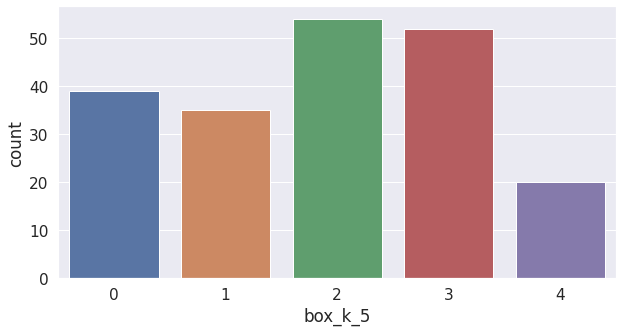

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x='box_k_5', data=df);

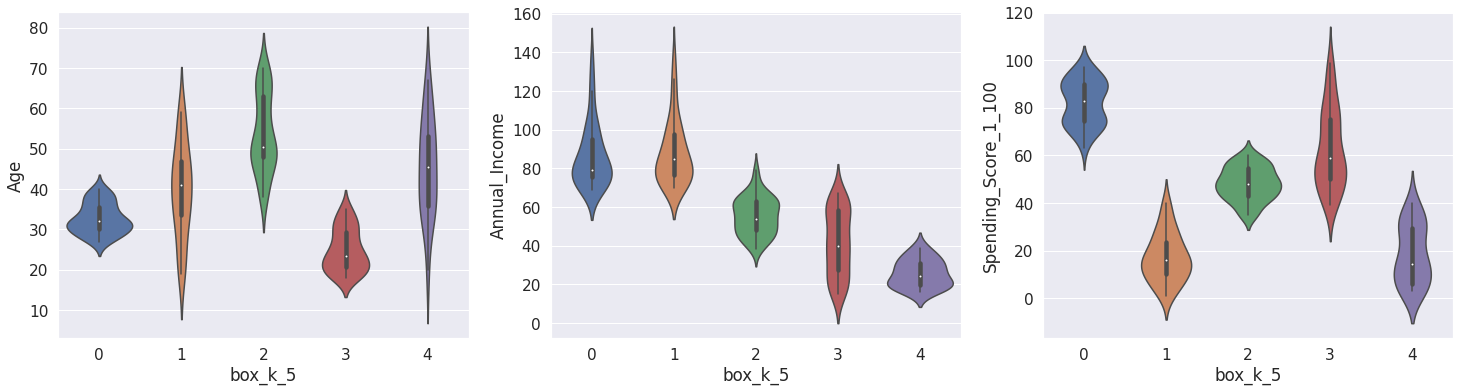

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,6))
ax = ax.ravel()
for pos, col in enumerate(COLUMNS):
  #use violinplot to see each cluster's variable is distrubuted
  sns.violinplot(x='box_k_5', y=col, data=df, ax=ax[pos])

**Box-Cox K = 5**
- custer 0 = กลุ่มวัยกลางคน มีรายได้มาก ใช้จ่ายมาก
- custer 1 = กลุ่มวัยกลางคน มีรายได้มาก ใช้จ่ายน้อย
- custer 2 = กลุ่มวัยก่อนเกษียณ มีรายได้กลางๆ ใช้จ่ายกลางๆ
- custer 3 = กลุ่มวัยทำงาน มีรายได้น้อย ใช้จ่ายมาก
- custer 4 = กลุ่มวัยกลางคน มีรายได้น้อย ใช้จ่ายน้อย

In [ ]:
features = df[COLUMNS]
umap_2d = umap.UMAP(n_components=2, init='random', random_state=SEED)
proj_2d = umap_2d.fit_transform(features)

In [ ]:
fig = go.Figure(data=go.Scatter(x=proj_2d[:,0], y=proj_2d[:,1],
                 mode="markers",
                 marker=dict(color=color_change_2d(df,'box_k_5',5),size=5,showscale=False)))
fig.update_layout(height=500, title_text="Visualizing 2D Clusters K=5", showlegend=False)
fig.show()

## Yeo-Johnson

### K=7

In [ ]:
model = KMeans(n_clusters=7,random_state=SEED)
model.fit(yeodf)
model.cluster_centers_.round(4)

array([[-0.6729,  1.0476, -1.6188],
       [-1.0962, -0.1142,  0.0156],
       [ 1.0528, -0.1674, -0.0072],
       [-0.3327,  0.9727,  1.2012],
       [ 0.4998, -1.4232, -1.2572],
       [-1.0699, -1.4467,  1.0386],
       [ 0.6823,  1.0197, -1.1632]])

In [ ]:
df.groupby('yeo_k_7')[COLUMNS].mean()

,Age,Annual_Income,Spending_Score_1_100
yeo_k_7,,,
0,29.363636,89.000000,10.454545
1,24.750000,55.781250,49.500000
2,54.137255,54.313725,48.862745
3,32.692308,86.538462,82.128205
4,45.400000,25.650000,18.550000
5,25.000000,25.260870,77.608696
6,47.333333,87.875000,20.416667


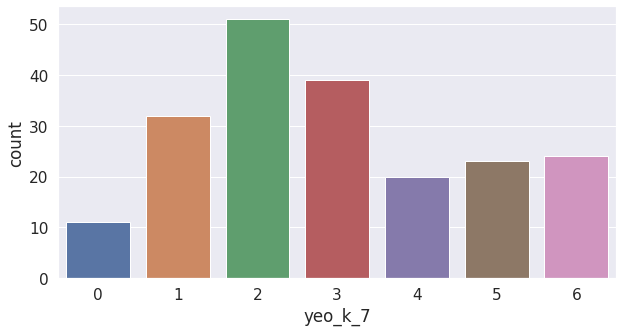

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x='yeo_k_7', data=df);

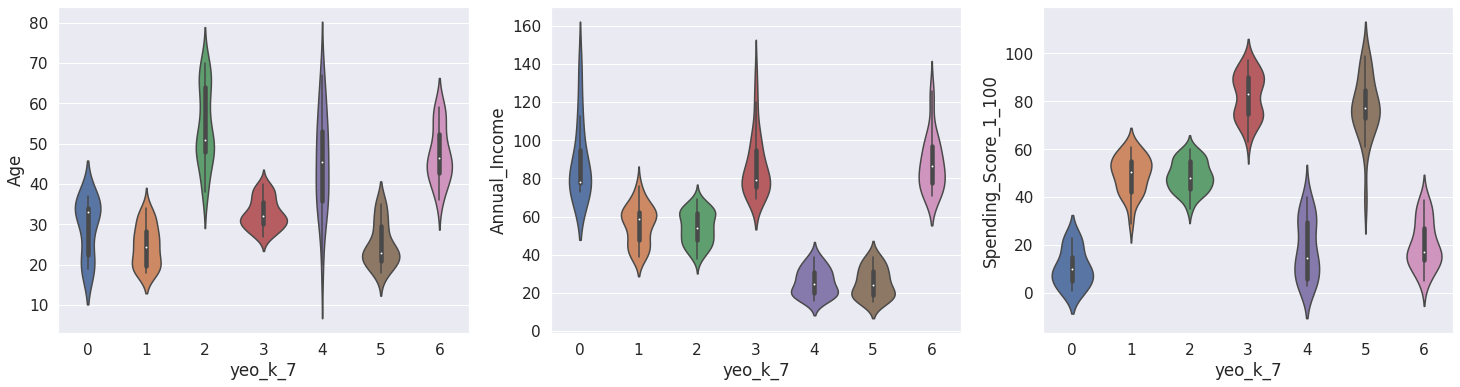

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,6))
ax = ax.ravel()
for pos, col in enumerate(COLUMNS):
  #use violinplot to see each cluster's variable is distrubuted
  sns.violinplot(x='yeo_k_7', y=col, data=df, ax=ax[pos])

**Yeo-Johnson K = 7**
- custer 0 = กลุ่มวัยทำงาน มีรายได้มาก ใช้จ่ายน้อย
- custer 1 = กลุ่มวัยทำงาน มีรายได้กลางๆ ใช้จ่ายกลางๆ
- custer 2 = กลุ่มวัยก่อนเกษียณ มีรายได้กลางๆ ใช้จ่ายกลางๆ
- custer 3 = กลุ่มวัยกลางคน มีรายได้มาก ใช้จ่ายมาก
- custer 4 = กลุ่มวัยกลางคน มีรายได้น้อย ใช้จ่ายน้อย
- custer 5 = กลุ่มวัยทำงาน มีรายได้น้อย ใช้จ่ายมาก
- custer 6 = กลุ่มวัยกลางคน มีรายได้มาก ใช้จ่ายน้อย

In [ ]:
features = df[COLUMNS]
umap_2d = umap.UMAP(n_components=2, init='random', random_state=SEED)
proj_2d = umap_2d.fit_transform(features)

In [ ]:
fig = go.Figure(data=go.Scatter(x=proj_2d[:,0], y=proj_2d[:,1],
                 mode="markers",
                 marker=dict(color=color_change_2d(df,'yeo_k_7',7),size=5,showscale=False)))
fig.update_layout(height=500,title_text="Visualizing 2D Clusters K=7", showlegend=False)
fig.show()


### K=6

In [ ]:
model = KMeans(n_clusters=6,random_state=SEED)
model.fit(yeodf)
model.cluster_centers_.round(4)

array([[ 1.0555, -0.15  , -0.0175],
       [-1.0145, -1.3887,  0.9899],
       [-0.3327,  0.9727,  1.2012],
       [ 0.4613,  1.0899, -1.2762],
       [ 0.4998, -1.4232, -1.2572],
       [-1.1876,  0.0104, -0.2133]])

In [ ]:
df.groupby('yeo_k_6')[COLUMNS].mean()

,Age,Annual_Income,Spending_Score_1_100
yeo_k_6,,,
0,54.173077,54.788462,48.596154
1,25.560000,26.480000,76.240000
2,32.692308,86.538462,82.128205
3,44.000000,90.133333,17.933333
4,45.400000,25.650000,18.550000
5,23.852941,59.088235,43.970588


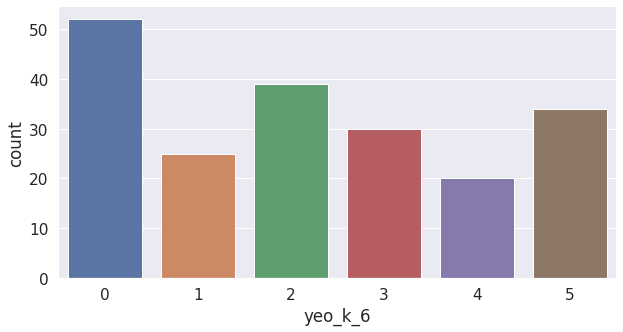

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x='yeo_k_6', data=df);

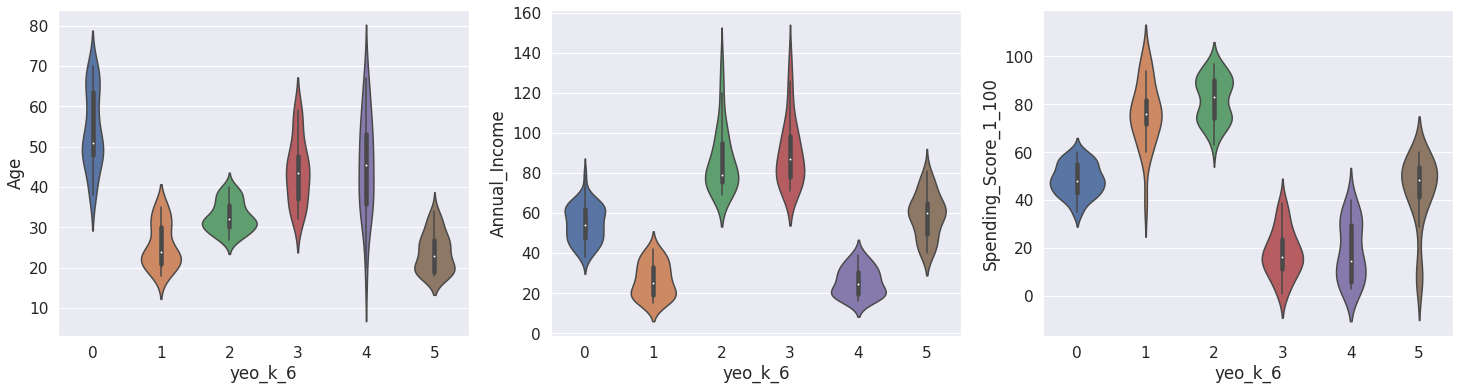

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,6))
ax = ax.ravel()
for pos, col in enumerate(COLUMNS):
  #use violinplot to see each cluster's variable is distrubuted
  sns.violinplot(x='yeo_k_6', y=col, data=df, ax=ax[pos])

**Yeo-Johnson K = 6**
- custer 0 = กลุ่มวัยก่อนเกษียณ มีรายได้กลางๆ ใช้จ่ายกลางๆ
- custer 1 = กลุ่มวัยทำงาน มีรายได้น้อย ใช้จ่ายมาก
- custer 2 = กลุ่มวัยกลางคน มีรายได้มาก ใช้จ่ายมาก
- custer 3 = กลุ่มวัยกลางคน มีรายได้มาก ใช้จ่ายน้อย
- custer 4 = กลุ่มวัยกลางคน มีรายได้น้อย ใช้จ่ายน้อย
- custer 5 = กลุ่มวัยทำงาน มีรายได้กลางๆ ใช้จ่ายกลางๆ

In [ ]:
features = df[COLUMNS]
umap_2d = umap.UMAP(n_components=2, init='random', random_state=SEED)
proj_2d = umap_2d.fit_transform(features)

In [ ]:
fig = go.Figure(data=go.Scatter(x=proj_2d[:,0], y=proj_2d[:,1],
                 mode="markers",
                 marker=dict(color=color_change_2d(df,'yeo_k_6',6),size=5,showscale=False)))
fig.update_layout(height=500,title_text="Visualizing 2D Clusters K=6", showlegend=False)
fig.show()

### K=5

In [ ]:
model = KMeans(n_clusters=5,random_state=SEED)
model.fit(yeodf)
model.cluster_centers_.round(4)

array([[-0.3327,  0.9727,  1.2012],
       [ 0.1029,  1.0195, -1.3099],
       [ 1.0383, -0.1236, -0.0363],
       [-1.0902, -0.74  ,  0.502 ],
       [ 0.4998, -1.4232, -1.2572]])

In [ ]:
df.groupby('yeo_k_5')[COLUMNS].mean()

,Age,Annual_Income,Spending_Score_1_100
yeo_k_5,,,
0,32.692308,86.538462,82.128205
1,39.657143,87.971429,17.200000
2,53.851852,55.500000,48.111111
3,24.826923,41.307692,62.807692
4,45.400000,25.650000,18.550000


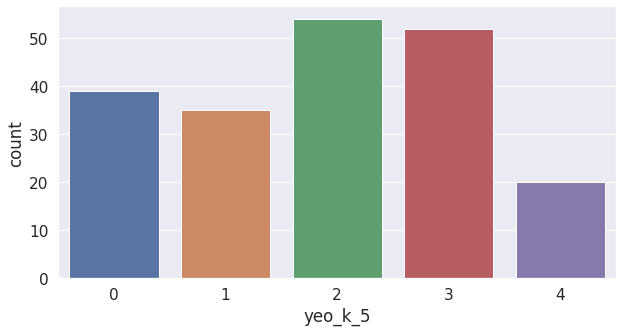

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x='yeo_k_5', data=df);

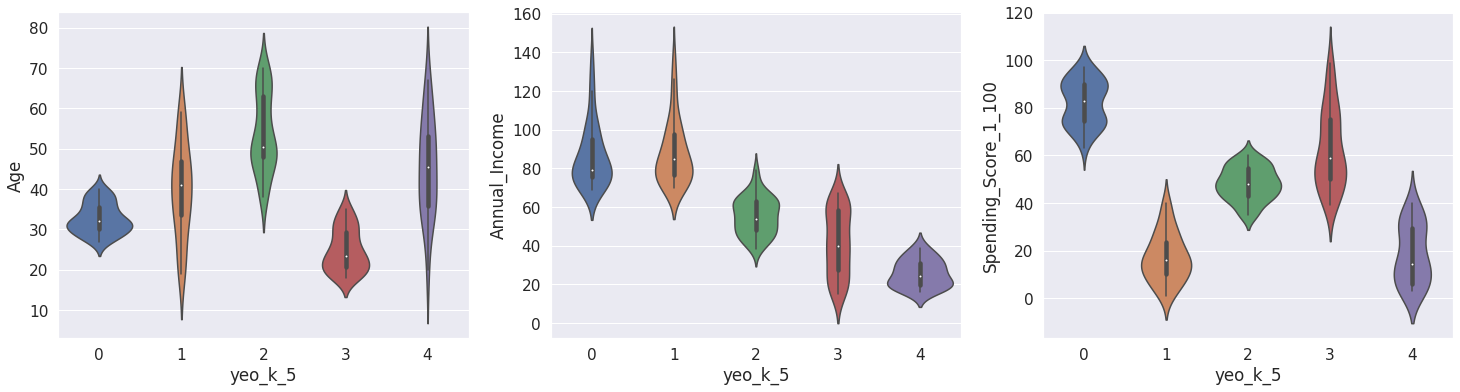

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,6))
ax = ax.ravel()
for pos, col in enumerate(COLUMNS):
  #use violinplot to see each cluster's variable is distrubuted
  sns.violinplot(x='yeo_k_5', y=col, data=df, ax=ax[pos])

**Yeo-Johnson K = 5**
- custer 0 = กลุ่มวัยกลางคน มีรายได้มาก ใช้จ่ายมาก
- custer 1 = กลุ่มวัยกลางคน มีรายได้มาก ใช้จ่ายน้อย
- custer 2 = กลุ่มวัยก่อนเกษียณ มีรายได้กลางๆ ใช้จ่ายกลางๆ
- custer 3 = กลุ่มวัยทำงาน มีรายได้น้อย ใช้จ่ายมาก
- custer 4 = กลุ่มวัยกลางคน มีรายได้น้อย ใช้จ่ายน้อย

In [ ]:
features = df[COLUMNS]
umap_2d = umap.UMAP(n_components=2, init='random', random_state=SEED)
proj_2d = umap_2d.fit_transform(features)

In [ ]:
fig = go.Figure(data=go.Scatter(x=proj_2d[:,0], y=proj_2d[:,1],
                 mode="markers",
                 marker=dict(color=color_change_2d(df,'yeo_k_5',5),size=5,showscale=False)))
fig.update_layout(height=500,title_text="Visualizing 2D Clusters K=5", showlegend=False)
fig.show()

## Conclusion

**K = 5**

สรุปแล้วจะได้ **Yeo-Johnson** จาก **Violin Plot** โดยสามารถจัด k ได้หลายกลุ่มแต่เราจะนำ k=5 มาจะสามารถจัดกลุ่มได้ชัดเจนที่สุด ทำให้ทราบว่า

ห้างสรรพสินค้าของเราสามารถจัดกลุ่มลูกค้าจากอายุ, รายได้และการใช้จ่าย ซึ่งเราสามารถนำข้อมูลลูกค้าที่จัดกลุ่ม นำมาประยุกต์ใช้เพื่อสามารถเลือกลูกค้าให้ตรงตามกลุ่มเป้าหมาย โดยกลุ่มเป้าหมายของเราแบ่งออกมาได้ 5 กลุ่ม

- custer 0 = กลุ่มวัยกลางคน มีรายได้มาก ใช้จ่ายมาก
- custer 1 = กลุ่มวัยกลางคน มีรายได้มาก ใช้จ่ายน้อย
- custer 2 = กลุ่มวัยก่อนเกษียณ มีรายได้กลางๆ ใช้จ่ายกลางๆ
- custer 3 = กลุ่มวัยทำงาน มีรายได้น้อย ใช้จ่ายมาก
- custer 4 = กลุ่มวัยกลางคน มีรายได้น้อย ใช้จ่ายน้อย

# Pipeline

In [ ]:
class Pipeline_mall():
  def __init__(self):
    self.transformer = PowerTransformer(method='yeo-johnson')
    self.columns = ['Age','Annual_Income','Spending_Score_1_100']
  #เปลี่ยนชื่อคอลัมน์ Annual Income (k$) => Annual_Income
  #เปลี่ยนชื่อคอลัมน์ Spending Score (1-100) => Spending_Score_1_100
  #เปลี่ยนค่าของข้อมูล Gender ให้ Male = 0 และ Female = 1
  #เปลี่ยนประเภทของ Gender จาก object ให้เป็น int
  def convert_data(self,data,method):
    if method == 'train':
      data.rename(columns= { 'Annual Income (k$)': 'Annual_Income'}, inplace=True )
      data.rename(columns= { 'Spending Score (1-100)': 'Spending_Score_1_100'}, inplace=True )
      data['Gender'] = data['Gender'].replace('Male','0')
      data['Gender'] = data['Gender'].replace('Female','1')
      data['Gender'] = data['Gender'].astype(int)
    return data
  #scale ข้อมูลเข้า model
  def feature_engineering(self,data,method):
    if method == 'train':
      data = self.transformer.fit_transform(data[self.columns])
    elif method == 'predict':
      data = self.transformer.transform(data[self.columns])
    return data
  #execute
  def execute(self,data,method):
    data = self.convert_data(data,method)
    data = self.feature_engineering(data,method)
    return data

In [ ]:
pipe_mall = pd.read_csv('/content/sample_data/Mall_Customers.csv')

In [ ]:
pipe = Pipeline_mall()
mall_data = pipe.execute(data = pipe_mall,method='train')

In [ ]:
kmeans = KMeans(n_clusters=5, init='k-means++',random_state=5)
kmeans.fit(mall_data)
labels = kmeans.labels_

#นำข้อมูล k ไปกระจายใน DataFrame
pipe_mall['k=5'] = labels

In [ ]:
pipe_mall.sample(20)

,CustomerID,Age,Annual_Income,Spending_Score_1_100,k=5
8,9,64,19,3,1
156,157,37,78,1,2
137,138,32,73,73,0
68,69,19,48,59,4
84,85,21,54,57,4
43,44,31,39,61,4
188,189,41,103,17,2
90,91,68,59,55,3
80,81,57,54,51,3
79,80,49,54,42,3


In [ ]:
pipe_mall = pipe_mall[['CustomerID','Age','Annual_Income','Spending_Score_1_100','k=5']]
pipe_mall

,CustomerID,Age,Annual_Income,Spending_Score_1_100,k=5
0,1,19,15,39,4
1,2,21,15,81,4
2,3,20,16,6,1
3,4,23,16,77,4
4,5,31,17,40,1
...,...,...,...,...,...
195,196,35,120,79,0
196,197,45,126,28,2
197,198,32,126,74,0
198,199,32,137,18,2


# Deployment

In [ ]:
!pip install gradio -q

In [ ]:
import gradio as gr

In [ ]:
#ผลลัพธ์ 10 คนที่อยู่ในคลัสเตอร์เดียวกับข้อมูลที่ถูก input มา
def getMall(index):
    findoutMall = pipe_mall.loc[pipe_mall['k=5'] == index]
    findoutMall.drop('k=5', axis=1, inplace=True)
    return findoutMall

In [ ]:
#นำข้อมูล input ไป scale เพื่อนำมา predict ข้อมูลที่ input อยู่ในคลัสเตอร์ไหน
def manageMall(Age,Annual_Income,Spending_Score_1_100):
  input = pd.DataFrame({
      'Age':Age,'Annual_Income':Annual_Income,'Spending_Score_1_100':Spending_Score_1_100
      }, index=[0])
  
  predict_mall = pipe.execute(input,method='predict')
  index_group = kmeans.predict(predict_mall)[0]
  returnMall = getMall(index_group)
  groups = ['กลุ่มวัยกลางคน มีรายได้มาก ใช้จ่ายมาก', 'กลุ่มวัยกลางคน มีรายได้มาก ใช้จ่ายน้อย',
            'กลุ่มวัยก่อนเกษียณ มีรายได้กลางๆ ใช้จ่ายกลางๆ', 'กลุ่มวัยทำงาน มีรายได้น้อย ใช้จ่ายมาก',
            'กลุ่มวัยกลางคน มีรายได้น้อย ใช้จ่ายน้อย']
  return groups[kmeans.predict(predict_mall)[0]],returnMall.head(10)

In [ ]:
Age = gr.inputs.Number(default="1", label='Age')
Annual_Income = gr.inputs.Number(default="1", label='Annual_Income')
Spending_Score_1_100 = gr.inputs.Number(default="1", label='Spending_Score_1_100')

In [ ]:
iface = gr.Interface(
    manageMall,
    outputs=[gr.outputs.Textbox(type="auto", label='Cluster'),gr.outputs.Dataframe(label="Mall")],
    inputs=[Age,
            Annual_Income,
            Spending_Score_1_100
            ])

iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://10075.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

